In [1]:
import pygame
import itertools
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
### unit converters ###

def cm(Input):
    # converts cm to pixels
    return Input/18.0

def m(Input):
    # converts m to pixels
    return cm(Input)/100

def kmh(Input):
    # converts km/h to pixels per frame
    return Input/25.92

def sec(Input):
    # converts seconds to frames
    return Input*40

In [3]:
### Global constants ###

H = 900
B = 250
L = 50

FPS = 60

MAX_SPEED = kmh(50)
FOLLOWING_TIME = sec(1)
BUFFER = 20

# Spawn parameters
SPAWN_PROBABILITY = 0.015
SPAWN_RATE = 30 # spawns per minute
spawn_increase_time = 60 #seconds
spawn_increase_value = 1 #spawns per minute (0 = no increase)

# Dimensions
CAR_WIDTH = cm(180)
CAR_LENGTH = (20,27)
TRUCK_LENGTH = (42,50)

TRUCK_PROBABILITY = 0.1
ACCELERATION = 0.02
DECELERATION = -0.02

LEFT = 1

begin_time1 = pygame.time.get_ticks()
begin_time2 = pygame.time.get_ticks()

# colors
WHITE = (240, 240, 245)
RED1 = (255, 100, 100)
RED2 = (220, 65, 65)
GREY1 = (150, 150, 150)

In [4]:
class Car():
    def __init__(self, length, path, lights):
        self.length = length
        self.sections, self.blockades = path
        self.i = 0
        self.distance = 0
        self.speed = MAX_SPEED
        self.acceleration = 0
        self.special_priority = False
        self.color = pygame.Color(0)
        self.color.hsla = (random.randint(0,360), 75, 25)
        self.start_time = pygame.time.get_ticks()/1000
        self.lights = lights
        
    def section(self):
        return self.sections[self.i]
    
    def position(self):
        return self.section().position(self.distance)
    
    def angle(self):
        return self.section().angle(self.distance)
    
    def find_next_car(self):
        for car in reversed(self.section().cars):
            if car.distance > self.distance:
                return car
        for section in self.sections[self.i+1:]:
            if section.cars:
                return section.cars[-1]
            
    def update_acceleration(self):
        next_car = self.find_next_car()
        self.acceleration = ACCELERATION
        
        if self.i == 1 and ((self.lights and not self.section().priority) or \
        (not self.lights and any(b.cars for b in self.blockades) and not self.special_priority)):
            space = self.sections[1].length - self.distance - self.length/2
            braking_distance = self.speed**2 / (2 * -DECELERATION)
            difference = space - braking_distance
            if 0 < difference < 10:
                self.acceleration = DECELERATION

        if next_car:
            space = next_car.distance - self.distance - \
                    (self.length + next_car.length)/2 - BUFFER
            
            for i in range(self.i, len(self.sections)):
                if self.sections[i] == next_car.section():
                    break
                space += self.sections[i].length
            
            acceleration = 2*(space - self.speed*FOLLOWING_TIME) / FOLLOWING_TIME**2
            if acceleration < self.acceleration:
                self.acceleration = acceleration

    def update_speed(self):
        self.speed = round(max(0, min(MAX_SPEED, self.speed + self.acceleration)),2)

    def update_distance(self):
        self.distance += self.speed
    
    def update_section(self):
        section = self.section()

        if self.distance > section.length:
            self.distance -= section.length
            section.cars.remove(self)
            self.i += 1
            
            if self.i < len(self.sections):
                self.section().cars.append(self)
            else:
                return True
                
    def update(self):
        self.update_acceleration()
        self.update_speed()
        self.update_distance()
        return self.update_section()
        

In [5]:
class Section():
    def __init__(self, x, y, a, b, length):
        self.x = x
        self.y = y
        self.a = a
        self.b = b
        self.length = length
        self.cars = []
        self.priority = False

In [6]:
class Line(Section):
    def position(self, s):
        return (self.x + self.a*s, self.y + self.b*s)

    def angle(self, s):
        return np.arctan2(-self.b, self.a)

In [7]:
class Curve(Section):
    def __init__(self, x, y, a, b, r):
        super().__init__(x, y, a, b, np.pi*r/2)
        self.r = r

    def position(self, s):
        c = self.a*np.pi/2 + self.b*s/self.r
        return (self.x+self.r*np.cos(c), self.y-self.r*np.sin(c))
    
    def angle(self, s):
        return (self.a+1)*np.pi/2 + self.b*s/self.r

In [8]:
class Intersection():
    def __init__(self, sections, paths, triggers, lights=False):
        self.sections = sections
        self.paths = paths
        self.triggers = triggers
        self.car_count = 0
        self.bike_count = 0
        self.cars_per_min = 0
        self.cars_per_min_list = []
        self.spawn_rate_list = []
        self.bikes_per_min = 0
        self.car_time_list = []
        self.average_travel_time = 0
        self.average_travel_time_list = []
        self.timer = 0
        self.lights = lights
    
    def cars(self):
        for section in self.sections:
            for car in section.cars:
                yield car
        
    def spawn_cars(self):
       
        global SPAWN_RATE
        global begin_time1
        global begin_time2
        global spawn_increase_time
        global spawn_increase_value
    
        SPAWN_RATE2 = 60/SPAWN_RATE 
        
        seconds1 = (pygame.time.get_ticks()-begin_time1)/1000
        
        if seconds1 > spawn_increase_time: 
            SPAWN_RATE += spawn_increase_value
            begin_time1 = pygame.time.get_ticks()
        
        seconds2 = (pygame.time.get_ticks()-begin_time2)/1000
        
        if seconds2 > SPAWN_RATE2:
            if random.random() < TRUCK_PROBABILITY:
                length = random.randint(*TRUCK_LENGTH)
            else:
                length = random.randint(*CAR_LENGTH)

            path = random.choice(self.paths)
            section0 = path[0][0]
            
            if not section0.cars or section0.cars[-1].distance > 80: 
                car = Car(length, path, self.lights)
                section0.cars.append(car)
                
            begin_time2 = pygame.time.get_ticks()

    def update_cars(self, t):
        if self.lights:
            for s in self.triggers:
                if s.priority and not s.cars:
                    s.priority = False
                    self.timer = t

            if t - self.timer > 60:
                if not any(s.priority for s in self.triggers):
                    occupied = [s for s in self.triggers if s.cars]
                    if occupied:
                        random.choice(occupied).priority = True
        else:
            if not t%60 and not any(s.cars and s.cars[0].speed for s in self.triggers):
                cars = [s.cars[0] for s in self.triggers if s.cars]
                if cars:
                    random.choice(cars).special_priority = True
            
        for section in self.sections:
            for car in section.cars:
                if car.update():
                    global SPAWN_RATE
                    self.current_time = pygame.time.get_ticks()/1000
                    self.current_second = round(self.current_time, 1)
                    
                    self.car_count += 1
                    # update cars per minute
                    self.cars_per_min = self.car_count/(self.current_time/60)
                    self.cars_per_min_list.append([self.current_second, self.cars_per_min])
                    # update travel times
                    self.car_time_list.append(round(self.current_time-car.start_time,3))
                    self.average_travel_time = np.mean(self.car_time_list)
                    self.average_travel_time_list.append([self.current_second, self.average_travel_time])
                    # update spawn rates
                    self.spawn_rate_list.append([self.current_second, SPAWN_RATE])

            
    def update(self, t):
        self.spawn_cars()
        self.update_cars(t)

In [9]:
class Graphics():
    def __init__(self):
        self.screen = pygame.display.set_mode((H, H))

    def center(self, points):
        return np.array(points) + H/2
    
    def draw_car(self, car):
        p, l, w, a = car.position(), car.length, CAR_WIDTH, car.angle()
        corners = [[-l/2,w/2], [l/2,w/2], [l/2,-w/2], [-l/2,-w/2]]

        for c in corners:
            temp =  c[0]*np.cos(a) - c[1]*np.sin(a) + p[0]
            c[1] = -c[0]*np.sin(a) - c[1]*np.cos(a) + p[1]
            c[0] = temp

        pygame.draw.polygon(self.screen, car.color, self.center(corners))
        
    def draw_stats(self, car_count):
        font = pygame.font.SysFont('Helvetica', 18)
        self.current_time = (pygame.time.get_ticks()-simulation.start_time)
        self.current_second = round(self.current_time/1000, 1)
        
        text_time =  font.render('Seconds past: ' + str(self.current_second), False, (0, 0, 0))
        text_count = font.render('Number of cars: ' + str(intersection.car_count) + ' cars', False, (0, 0, 0))
        text_cars_per_minute = font.render('Cars per minute: ' + str(round(intersection.cars_per_min, 2)) + ' cars', False, (0, 0, 0))
        text_average_travel_time = font.render('Average travel time: ' + str(round(intersection.average_travel_time, 2))+' sec', False, (0, 0, 0))
        
        self.screen.blit(text_time,(20,20))
        self.screen.blit(text_count,(20,40))
        self.screen.blit(text_cars_per_minute,(20,60))
        self.screen.blit(text_average_travel_time,(20,80))

    def draw_sim(self, intersection, button_data, text_data, lines_data):
        
        # Draw Background:
        self.screen.fill((80, 150, 80)) 
        
        # Draw Buttons:
        buttons = button_data.copy()
        lines = lines_data.copy()

        
        for name in button_data:
            buttons[name] = pygame.draw.rect(self.screen, *buttons[name])
        
        for name in lines_data:
            lines[name] = pygame.draw.line(self.screen, *lines[name])

        for text, size, x, y in text_data:
            font = pygame.font.Font('freesansbold.ttf', size)
            text = font.render(text, True, WHITE)
            rect = text.get_rect(center=(x,y))
            self.screen.blit(text, rect)
            
        # Draw Cars:
        for car in intersection.cars():
            self.draw_car(car)

        self.draw_stats(intersection.car_count)
        
        pygame.display.flip()
        return buttons
        
    def draw_menu(self, button_data, text_data):
        buttons = button_data.copy()
        self.screen.fill((100,100,100))

        for name in button_data:
            buttons[name] = pygame.draw.rect(self.screen, *buttons[name])

        for text, size, x, y in text_data:
            font = pygame.font.Font('freesansbold.ttf', size)
            text = font.render(text, True, WHITE)
            rect = text.get_rect(center=(x,y))
            self.screen.blit(text, rect)

        pygame.display.flip()
        return buttons

In [10]:
class Simulation():
    def __init__(self, intersection, clock, graphics):
        self.intersection = intersection
        self.clock = clock
        self.graphics = graphics
        self.start_time = pygame.time.get_ticks()
        
        self.buttons = {'reset': (RED1, (740, 20, 100, 40)), 
                        'quit': (RED1, (740, 80, 100, 40)),
                       'street_A': (GREY1, (0, 400, 900, 100)),
                       'street_B': (GREY1, (400, 0, 100, 900))}
        
        self.lines = {'middle_A': (WHITE, (0,450),(900,450), 5),
                     'middle_B': (WHITE, (450,0),(450,900), 5)}
        
        self.text =   (('Reset', 21, 790, 40),        ('Quit', 21, 790, 100))
        
    def run(self):
        buttons = self.graphics.draw_sim(self.intersection, self.buttons, self.text, self.lines)
        
        for t in itertools.count():
                
            self.clock.tick(FPS)
            self.intersection.update(t)
            self.graphics.draw_sim(self.intersection, self.buttons, self.text, self.lines)

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                elif event.type == pygame.MOUSEBUTTONDOWN and event.button == LEFT:
                    for name in buttons: 
                        if buttons[name].collidepoint(event.pos):
                            return name

In [11]:
class Menu():
    def __init__(self, designs, clock, graphics):
        self.designs = designs
        self.clock = clock
        self.graphics = graphics
        self.i = 0
        
        self.buttons = {'start': (RED1, (250,250,400,40)),    'design': (RED1, (290, 310, 320, 40)),
                        'prev':  (RED2, (250, 310, 40, 40)),  'next':   (RED2, (610, 310, 40, 40)),
                        'about': (RED1, (250, 370, 400, 40)), 'quit':   (RED1, (250, 430, 400, 40))}
        
        self.text =   (('Traffic Flow', 64, 450, 100), ('By Ravi & Jelle', 21, 450, 150),
                       ('Start', 21, 450, 270),        ['', 21, 450, 330], 
                       ('Prev', 16, 269, 331),         ('Next', 16, 629, 331), 
                       ('About', 21, 450, 390),        ('Quit', 21, 450, 450))
        
    def update(self):
        self.text[3][0] = 'Design: ' + self.designs[self.i].__name__.replace('_',' ')
        return self.graphics.draw_menu(self.buttons, self.text)
        
    def run(self):
        buttons = self.update()
        
        while True:
            self.clock.tick(FPS)

            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
                    
                elif event.type == pygame.MOUSEBUTTONDOWN and event.button == LEFT:
                    for name in buttons: 
                        if buttons[name].collidepoint(event.pos):
                            if name == 'start': 
                                return self.designs[self.i]
                            elif name == 'prev':
                                self.i = max(0, self.i - 1)
                                self.update()
                            elif name == 'next':
                                self.i = min(len(self.designs) - 1, self.i + 1)
                                self.update()
                            elif name == 'quit':
                                pygame.quit()
                                sys.exit()

In [12]:
def basic_intersection(blockades=tuple([[]]*12)):
    sections = [Line(L/2, H/2, 0, -1, H/2-L-B),
                Line(L/2, L+B, 0, -1, B),
                Line(L/2, L, 0, -1, L),
                Line(L/2, 0, 0, -1, L),
                Line(L/2, -L, 0, -1, H/2-L),
                Curve(L, L, 2, -1, L/2),
                Curve(0, 0, 0, 1, L/2)]
    
    for _ in range(3):
        for s in sections[-7:]:
            if isinstance(s, Line):
                sections.append(Line(s.y,-s.x,s.b,-s.a,s.length))
            else:
                sections.append(Curve(s.y,-s.x,s.a+1,s.b,s.r))
    
    l = ((0,1,2,3,4), (0,1,5,25), (0,1,2,6,10,11))
    paths = [[sections[(n+i*7)%28] for n in p] for i in range(4) for p in l]
    triggers = [sections[n*7+1] for n in range(4)]
    paths = list(zip(paths, [[triggers[n] for n in t] for t in blockades]))
    return sections, paths, triggers

In [13]:
def Free_crossing():
    blockades = ([1],[],[1,2],[2],[],[2,3],[3],[],[3,0],[0],[],[0,1])
    return basic_intersection(blockades)

In [14]:
def Shark_teeth():
    blockades = ([1,3],[3],[1,2,3],[],[],[3],[3,1],[1],[3,0,1],[],[],[1])
    return basic_intersection(blockades)

In [15]:
def Traffic_lights():
    return basic_intersection() + (True,)

In [16]:
def plot_data(data):

    travel_times_x = [value[0] for value in data[0]]
    travel_times_y = [value[1] for value in data[0]]
    
    car_rates_x = [value[0] for value in data[1]]
    car_rates_y = [value[1] for value in data[1]]
    
    spawn_rates_x = [value[0] for value in data[2]]
    spawn_rates_y = [value[1] for value in data[2]]
    
    plt.figure(figsize=(12, 12))
    
    plt.plot(car_rates_x, car_rates_y, label = 'Cars per min', color = '#7a0099')
    plt.plot(travel_times_x, travel_times_y, label = 'Average travel time',  color = '#3333cc')
    plt.plot(spawn_rates_x,spawn_rates_y, label = 'Spawn rate', color = '#999999')
    
    plt.xlabel('Time (in seconds)')
    plt.ylabel('Value')

    plt.title("Traffic flow simulation")
    plt.legend()
    plt.show()
    
def data_stats(data):
    
    travel_times_A = [value[1] for value in data[0]]    
    car_rates_A = [value[1] for value in data[1]]    
    
    # Test:
    travel_times_B = [value[1]*1.2 for value in data[0]]    
    car_rates_B = [value[1]*1.2 for value in data[1]]    
    
    travel_times_T = stats.ttest_ind(travel_times_A, travel_times_B)
    car_rates_T = stats.ttest_ind(car_rates_A, car_rates_B)
    
    print('Max travel time: ',  np.amax(travel_times_A))
    print('Mean Average travel time: ', np.mean(travel_times_A))
    print('Max car rate: ',  np.amax(car_rates_A))
    print('Mean Average cars per minute: ', np.mean(car_rates_A))
    print('')
    print('Student T test:')
    print('T travel: ', travel_times_T)
    print('T cars: ', car_rates_T)
    
    

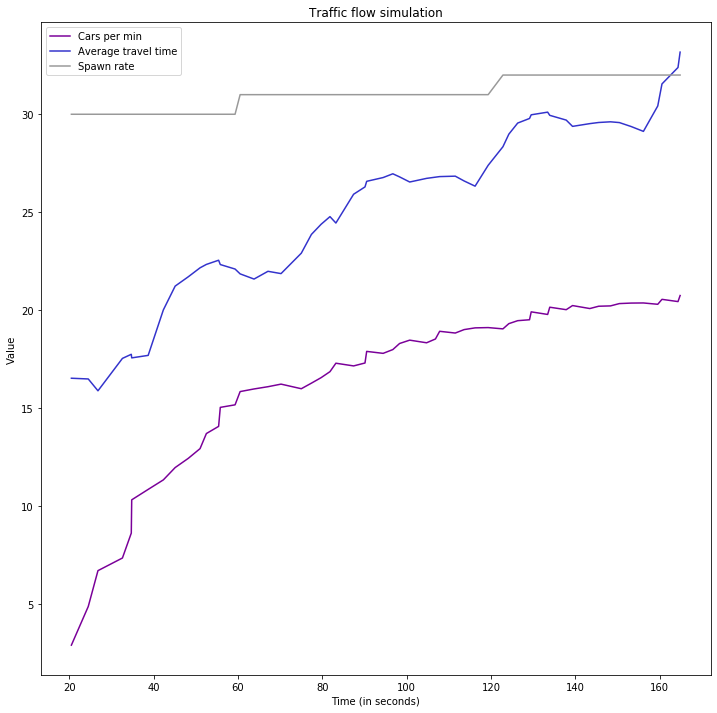

Max travel time:  33.16884210526316
Mean Average travel time:  25.35413332636824
Max car rate:  20.754694080664148
Mean Average cars per minute:  16.5570881506885

Student T test:
T travel:  Ttest_indResult(statistic=-5.504068797867392, pvalue=2.381179874357923e-07)
T cars:  Ttest_indResult(statistic=-3.744991121884703, pvalue=0.0002866605092822197)


In [ ]:
pygame.init()
pygame.display.set_caption('Traffic Flow')
clock = pygame.time.Clock()

graphics = Graphics()
designs = [Free_crossing, Shark_teeth, Traffic_lights]

while True:
    menu = Menu(designs, clock, graphics)
    design = menu.run()
    
    while True:
        intersection = Intersection(*design())
        simulation = Simulation(intersection, clock, graphics)
        if simulation.run() == 'quit':
            
            # Save data
            data = [intersection.average_travel_time_list,
                    intersection.cars_per_min_list,
                    intersection.spawn_rate_list]
            plot_data(data)
            data_stats(data)
            
            break